In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.datasets import fetch_openml #anotar na caixa de ferramentas
fashion = fetch_openml('fashion-mnist', version=1, parser='auto', as_frame=False) #as_frame=False para não precisar tratar como DF do pandas

In [3]:
fashion.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = fashion['data'], fashion['target']

In [5]:
X.shape #70 mil imagens com 784 caracterísiticas (28x28), onde cada característica é um pixel de 0 (branco) à 255 (preto)

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
cloth = X[9]
cloth_image = cloth.reshape(28,28) # precisamos dar reshape na array para formar uma imagem

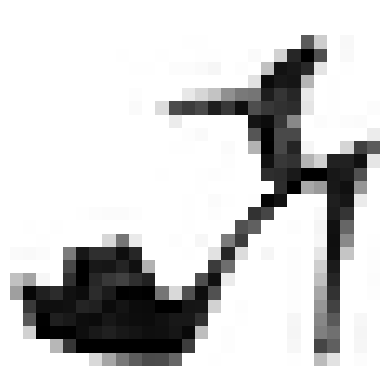

In [8]:
plt.imshow(cloth_image, cmap='binary')
plt.axis('off') #tira a grade da imagem
plt.show()

In [9]:
y[9]

'5'

In [10]:
y = y.astype(np.uint8) #Como algoritmos de ML precisam de números, convertemos y (string) para inteiro
#anotar na caixa de ferramentas

In [11]:
# X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] # divisão para mnist
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #USAR COMO PADRÃO (caso não tenha exceções nos dados)
#precisa ter o stratify=y para funcionar conforme o StratifiedKFold

In [12]:
# criamos um vetor-target 5 para distinguir entre 5 e não-5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42) #necessário ter pois SGDC depende de  aleatoriedade nas classificações, por isso Estocástico. (Stochastic Gradient Decay)
sgd_clf.fit(X_train, y_train_5)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [14]:
sgd_clf.predict([cloth]) # está classificando corretamente

array([ True])

In [15]:
#Como fazer uma validação cruzada com mais controle do que no cross_val_score:

#importar pacotes
from sklearn.model_selection import StratifiedKFold #divide os dados em partes (k) para treino e teste, garantindo a proporcionalidade em cada classe
from sklearn.base import clone #cria uma cópia limpa de um estimador ou modelo

In [16]:
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True) # colocar na caixa de ferramentas

In [17]:
#skfolds.split está gerando arrays de numeros inteiros a cada iteração, dando a "coordenada" para quais linhas usar. Isso fatia nossos dados originais
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  #Clonamos o modelo de forma virgem, se não fizessemos isso, no fold 1 ele aprenderia os dados, e no fold 2 continuaria aprendendo em cima do que aprendeu no fold 1
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds) #estuda os dados para poder prever
    y_pred = clone_clf.predict(X_test_folds) # faz a predição
    n_correct = sum(y_pred == y_test_folds) #soma o numero de predições que acertaram
    print(n_correct / len(y_pred)) #print da % de acurácia para cada fold

0.9776075427224514
0.9690362672095141
0.9799099967855995


In [18]:
# como fazer com cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9778754 , 0.97492902, 0.97782064])

In [19]:
#matriz de confusão
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # definimos as predições para serem comparadas com os valores reais

In [20]:
from sklearn.metrics import confusion_matrix
cf_mtx = confusion_matrix(y_train_5, y_train_pred)
cf_mtx

array([[49680,   720],
       [  575,  5025]])

In [21]:
# cálculo manual
print("Precision:", cf_mtx[1, 1] / (cf_mtx[1, 1] + cf_mtx[0, 1]))
print("Recall:", cf_mtx[1, 1] / (cf_mtx[1, 1] + cf_mtx[1, 0]))

Precision: 0.8746736292428199
Recall: 0.8973214285714286


In [22]:
#cálculo automático do sklearn
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8746736292428199

In [23]:
recall_score(y_train_5, y_train_pred)

0.8973214285714286

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred) #f1 score signfica a média harmônica das precisões e revocações, onde diferentemente da média normal, a média harmônica dá mais peso para valores baixos.

0.8858527985896871

In [25]:
# como escrito no caderno, as decisões que o SGDClassifier toma é a partir de scores, e com uma função de decisão ele adiciona a classificação. Com isso existem limiares, por isso vamos trazer os scores que o SGDC faz para cada instância
y_scores = sgd_clf.decision_function([cloth])
y_scores

array([36961.72060016])

In [26]:
threshold = 0 #o valor acima mostra qual o score de decisão da função, estamos testando como o limiar afeta a decisão
y_cloth_pred = (y_scores > threshold)
y_cloth_pred

array([ True])

In [27]:
threshold = 36962 #aqui, apenas 1 ponto acima do score de decisão mostra que a classificação perde um TP (true positive), onde prova que aumentar o limiar diminui a revocação.
y_cloth_pred = (y_scores > threshold)
y_cloth_pred

array([False])

In [28]:
# para decidir qual limiar utilizar, chamamos cross_val_predict com o method="decision_function". Com isso, teremos todos os scores de decisão de todas as instâncias da base de dados.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [29]:
# Para calcular precisão e revocação de todas as instâncias, usamos a funçao precision_recall_curve, apenas precisamos definir que precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

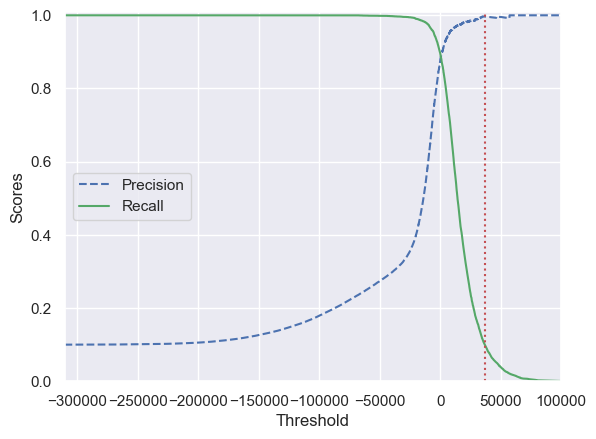

In [30]:
def plt_preci_recall_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--",label="Precision") # Utilizamos o [:-1] (slicing) para pegar todos os elementos, menos o último. o precision_recall_curve cria uma última precision ou recall igual a 0, sendo 1 a mais que o thresholds, para isso pegamos todos os elementos exceto o último.
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") #"b--" significa linha pontilhada azul e "g-" siginifica linha sólida verde
    # o autor não mostra como fazer o restante das configurações do plot, então inventei algumas para parecer com o plot do livro
    plt.legend(loc="center left") #ou outra como loc="best"
    plt.grid(True)

    plt.axvline(x=threshold, color='r', linestyle='dotted')
    #plt.axhline(y=threshold-1000, color='g', linestyle='dotted')

    plt.xlabel("Threshold") # Label normal
    plt.ylabel("Scores")
    plt.axis([-310000, 100000, 0, 1.01])

plt_preci_recall_thresholds(precisions, recalls, thresholds) #precisamos puxar os dados da função acima
plt.show()

In [31]:
# Se quisermos especificar uma % de precisão, podemos usar o seguinte código
threshold_90_preci = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_preci

np.float64(1674.9397397861608)

In [32]:
y_train_pred_90 = (y_scores >= threshold_90_preci)
precision_score(y_train_5, y_train_pred_90)

0.9000556276654923

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.8667857142857143

# Curva ROC

In [34]:
#a explicação de sensibilidade e especificidade foi feita no caderno, o ponto que iremos ver a seguir é sobre a plotagem dos TPRs (True positive rate) e dos FPRs (False positive rate).

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

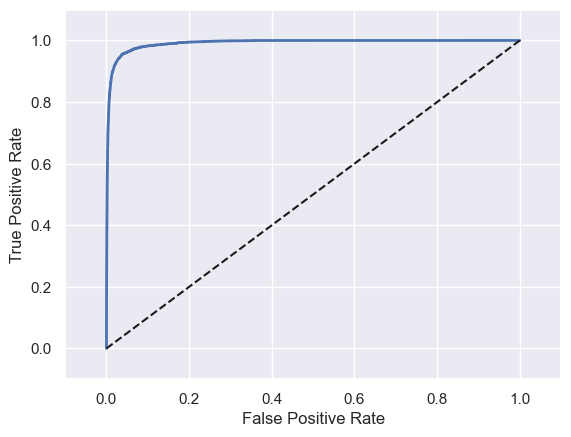

In [35]:
# fazemos uma função para poder plotar a curva ROC, da seguinte forma

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #diagonal tracejada
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9914685019841268

# RandomForestClassifier

In [37]:
#Devido ao modo como Random Forest funciona, o Classifier não tem um metodo decision_function(). Ele possui o predicit_proba()
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42) #define o modelo

In [38]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba") # faz as probabilidades através da cross validation

In [39]:
y_scores_forest = y_probas_forest[:, 1] #score= probabilidade de classe positiva
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

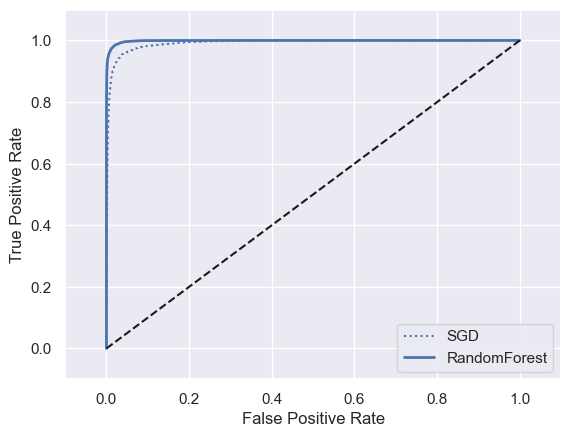

In [40]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc="lower right")
plt.show()

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9988166595804988

In [42]:
y_train_pred_forest = (y_scores_forest >= 0.5)
precision_score(y_train_5, y_train_pred_forest)

0.9828701941377997

In [43]:
recall_score(y_train_5, y_train_pred_forest)

0.9221428571428572

In [44]:
confusion_matrix(y_train_5, y_train_pred_forest)

array([[50310,    90],
       [  436,  5164]])

In [45]:
# Vou testar o gridsearch para ver se o modelo se adapta melhor ainda
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300],
    'max_features': [3],
    'max_depth': [None, 6],
    'min_samples_leaf': [1, 3],
    'min_samples_split': [2, 4],
    'max_leaf_nodes': [None],
    'bootstrap': [True]
}

In [46]:
grid_search_RFC = GridSearchCV(forest_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [47]:
grid_search_RFC.fit(X_train, y_train_pred_forest)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'bootstrap': [True], 'max_depth': [None, 6], 'max_features': [3], 'max_leaf_nodes': [None], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- 

In [48]:
grid_search_RFC.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 3,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [49]:
grid_search_RFC.best_score_

np.float64(0.9927500165773049)

In [50]:
# Reteste com melhores parâmetros
param_grid = {
    'bootstrap': [True],
     'max_depth': [None, 10],
     'max_features': [3, 6, 9],
     'max_leaf_nodes': [None],
     'min_samples_leaf': [1, 5],
     'min_samples_split': [1, 2],
     'n_estimators': [300, 600, 900]
}

In [51]:
grid_search_RFC = GridSearchCV(forest_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [52]:
grid_search_RFC.fit(X_train, y_train_pred_forest)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\felipetp\PycharmProjects\classification-handsOnML\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
108 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\felipetp\PycharmProjects\classification-handsOnML\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\felipetp\PycharmProjects\classification-handsOnML\.venv\Lib\site-packages\sklearn\base.py", line 1329, in wrapper
    estimator._validate_params()
    ~~~~~~~~~

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'bootstrap': [True], 'max_depth': [None, 10], 'max_features': [3, 6, ...], 'max_leaf_nodes': [None], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is dis

In [54]:
grid_search_RFC.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 9,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 900}

In [56]:
grid_search_RFC.best_score_

np.float64(0.994910723848966)

In [57]:
forest_clf = grid_search_RFC.best_estimator_

In [58]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba") # faz as probabilidades através da cross validation

In [59]:
y_scores_forest = y_probas_forest[:, 1] #score= probabilidade de classe positiva
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

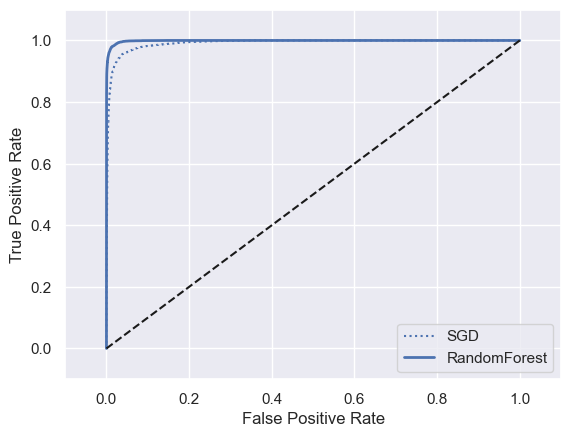

In [60]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc="lower right")
plt.show()

In [61]:
roc_auc_score(y_train_5, y_scores_forest)

0.998970702239229

In [62]:
y_train_pred_forest = (y_scores_forest >= 0.5)
precision_score(y_train_5, y_train_pred_forest)

0.9853705486044273

In [63]:
recall_score(y_train_5, y_train_pred_forest)

0.9141071428571429

In [64]:
confusion_matrix(y_train_5, y_train_pred_forest)

array([[50324,    76],
       [  481,  5119]])

# Classificação Multiclasse

In [45]:
# Ver anotações sobre OvR e OvO no caderno
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) #y_train, e não y_train_5
svm_clf.predict([cloth])

array([5], dtype=uint8)

In [46]:
cloth_scores = svm_clf.decision_function([cloth])
cloth_scores
# ele da scores para cada imagem baseado em cada classe, porém a com maior score é a que ele classifica (no caso classe 5)

array([[ 3.78050531, -0.30307784,  3.77133916,  1.72334359,  0.71498238,
         9.31655466,  5.09601034,  4.7377208 ,  7.28815803,  8.24898447]])

In [47]:
np.argmax(cloth_scores)

np.int64(5)

In [48]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [49]:
#podemos forçar o SKLearn a usar OvO ou OvR:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([cloth])

array([5], dtype=uint8)

In [50]:
len(ovr_clf.estimators_)

10

In [51]:
sgd_clf.decision_function([cloth])

array([36961.72060016])

In [52]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, n_jobs=-1, scoring='accuracy')

array([0.80269995, 0.72834414, 0.78152791])

In [53]:
#Escalonamento das entradas para poder ajustar os dados e melhorar a acurácia do modelo
#o escalonamento é feito por conta de os valores irem de 0 à 255, não é muito porém é um range grande
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # cria uma instância do padronizador, ajusta os dados para média 0 e desvio padrão 1
# Definimos uma variável com os valores escalonados
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

#fit (ajustar) calcula a média e o desvio padrão dos dados de treino, transform aplica a fórmula matemática (subtrai a média e divide pelo desvio padrão) para transformar os dados
#X_train.astype(np.float64) converte os dados de entrada pra float64, evitando erros de arredondamento durante os cálculos.

In [54]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1, scoring='accuracy')

array([0.83409225, 0.83457438, 0.83317261])

In [59]:
#Análise de erro
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

C:\Users\felipetp\PycharmProjects\classification-handsOnML\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\felipetp\PycharmProjects\classification-handsOnML\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\felipetp\PycharmProjects\classification-handsOnML\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [60]:
confusion_mx = confusion_matrix(y_train, y_train_pred)
confusion_mx

array([[4414,   18,   88,  419,   22,    1,  550,    0,   88,    0],
       [  14, 5307,   43,  174,   18,    0,   40,    0,    4,    0],
       [  39,    4, 4066,  113,  718,    0,  596,    0,   64,    0],
       [ 213,   92,   73, 4843,  174,    0,  192,    0,   13,    0],
       [   4,    8,  590,  340, 4128,    0,  507,    0,   23,    0],
       [   3,    1,    3,   10,    0, 5117,   14,  272,   74,  106],
       [ 737,   12,  611,  348,  478,    0, 3228,    1,  185,    0],
       [   0,    0,    0,    0,    0,  244,    0, 5107,   15,  234],
       [  36,    3,   26,  114,   28,    8,  126,   31, 5224,    4],
       [   0,    1,    0,    6,    0,   88,    7,  225,    6, 5267]])

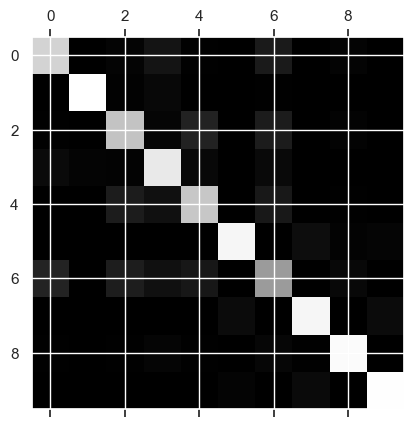

In [61]:
plt.matshow(confusion_mx, cmap=plt.cm.gray)
plt.show()

# Generalização do modelo

In [55]:
forest_clf.fit(X_train_scaled, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [56]:
X_test_scaled = scaler.transform(X_test.astype(np.float64))

In [57]:
y_pred = forest_clf.predict(X_test_scaled)

In [75]:
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precisão: {prec}")
print(f"Revocação: {rec}")
print(f"F1-Score: {f1}")

Precisão: 0.8807747003823329
Revocação: 0.8819285714285714
F1-Score: 0.880094130146073


In [66]:
y_proba = forest_clf.predict_proba(X_test_scaled)
y_proba.shape

(14000, 10)

In [67]:
y_proba_pos = y_proba[:, 1]

In [76]:
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print(f"ROC-AUC: {roc_auc:.3f}")

ROC-AUC: 0.990


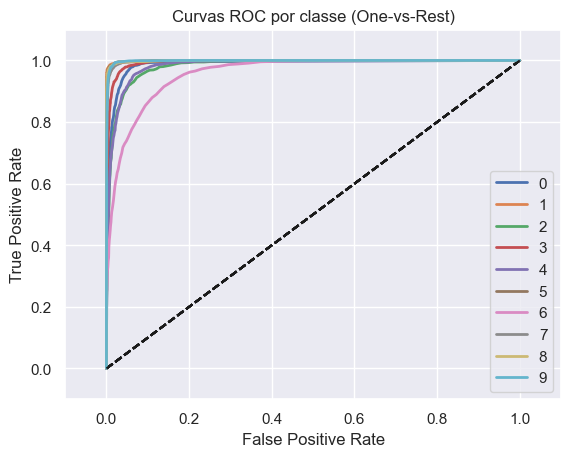

In [74]:
# Itera sobre cada classe
for i, classe in enumerate(forest_clf.classes_):
    # Binariza o y_test para a classe atual
    y_true_bin = (y_test == classe).astype(int)

    # Calcula curva ROC para essa classe
    fpr, tpr, thresholds = roc_curve(y_true_bin, y_proba[:, i])

    # Plota curva ROC
    plot_roc_curve(fpr, tpr, classe)
plt.title("Curvas ROC por classe (One-vs-Rest)")
plt.legend(loc="best")
plt.show()